# Data Preparation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import combinations
import random
import re
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/raw-data/lyrics-data.csv')
df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [3]:
df_art = pd.read_csv('../data/raw-data/artists-data.csv')
df_art.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [4]:
df = df[df['language']=='en'].reset_index(drop=True)

## Genre

In [5]:
genres = []
for artist_id in tqdm(df['ALink']):    
    artist_row = df_art[df_art['Link']==artist_id].reset_index()
    try:
        genres_in_artist = artist_row['Genres'][0].split('; ')        
    except:
        genres_in_artist = []
    genres.append(genres_in_artist)

100%|██████████| 191814/191814 [02:45<00:00, 1159.12it/s]


In [6]:
df.drop(columns = ['ALink', 'SName', 'SLink', 'language'], inplace=True)
df.rename(columns={'Lyric': 'lyrics'}, inplace=True)

In [7]:
genres = pd.Series(genres)
# Convert nested list into one-hot-encoding
mlb = MultiLabelBinarizer()
genres_one_hot = pd.DataFrame(mlb.fit_transform(genres),
                    columns=mlb.classes_,
                    index=genres.index)
genres_one_hot.head()

,Axé,Black Music,Blues,Bossa Nova,COLETÂNEA,Chillout,Classic Rock,Clássico,Country,Dance,...,Soul Music,Surf Music,Tecnopop,Trance,Trap,Trilha Sonora,Trip-Hop,Tropical House,Velha Guarda,World Music
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
genres_one_hot.sum().sort_values(ascending=False)[:10]

Rock           63717
Pop            33571
Pop/Rock       26360
Heavy Metal    21759
Hip Hop        20902
Indie          20134
Romântico      17947
Hard Rock      17250
Rap            17114
R&B            15581
dtype: int64

In [9]:
# Keep only the 8 most frequent genres (some of them will also be merged)
genres2keep = genres_one_hot.sum().sort_values(ascending=False)[:9].keys()

# Format labels
format_label = lambda s: s.lower().replace(' ', '-').replace('/', '-')

genres_one_hot = genres_one_hot[genres2keep]
genres_one_hot.rename(columns = dict([(
    genre_label, format_label(genre_label)) 
    for genre_label in genres_one_hot.keys()]), inplace=True)

In [10]:
df = pd.concat([df, genres_one_hot], axis=1)

In [11]:
genre_labels = [label for label in df.keys() if label != 'lyrics']

# Remove lyrics that do not fit into the main genres
df.drop(df[df[genre_labels].sum(axis=1) == 0].index, inplace=True)

In [12]:
jaccard_similarity = lambda x, y: np.logical_and(x, y).sum() / np.logical_or(x, y).sum()

genre_pairs = list(combinations(genre_labels, 2))

genre_similarities = [jaccard_similarity(df[genre_pair[0]], df[genre_pair[1]]) 
    for genre_pair in genre_pairs]

sorted(list(zip(genre_pairs, genre_similarities)),
    reverse=True, key=lambda x: x[1])[:20]

[(('hip-hop', 'rap'), 0.5317297231959386),
 (('heavy-metal', 'hard-rock'), 0.29537756525204223),
 (('rock', 'hard-rock'), 0.2094735898661568),
 (('pop', 'pop-rock'), 0.20258854218922445),
 (('rock', 'heavy-metal'), 0.15670672296200064),
 (('pop', 'romântico'), 0.13970311704975333),
 (('rock', 'pop-rock'), 0.13782431852057703),
 (('pop-rock', 'romântico'), 0.10936678434612784),
 (('rock', 'indie'), 0.10295433021151215),
 (('pop', 'hip-hop'), 0.058550330353672755),
 (('rock', 'romântico'), 0.0391540585593037),
 (('pop-rock', 'indie'), 0.03575486199291586),
 (('pop', 'rap'), 0.03301742586365026),
 (('pop', 'indie'), 0.02956118321415563),
 (('rock', 'pop'), 0.029502645502645503),
 (('indie', 'romântico'), 0.029299672946455118),
 (('pop-rock', 'hard-rock'), 0.012772875058058523),
 (('rock', 'hip-hop'), 0.007644950403086559),
 (('indie', 'hard-rock'), 0.007030681787571048),
 (('romântico', 'hard-rock'), 0.005513655582219175)]

In [13]:
# Merge together rap and hip hop
df['rap'] = np.logical_or(df['rap'], df['hip-hop']).replace({True: 1, False: 0})
# Drop columns
df.drop(columns=['romântico'], inplace=True)
df.drop(columns=['hip-hop'], inplace=True)
# Remove again lyrics that do not fit into the genres kept
genre_labels = [label for label in df.keys() if label != 'lyrics']
df.drop(df[df[genre_labels].sum(axis=1) == 0].index, inplace=True)

In [14]:
df.reset_index(inplace=True, drop=True)
print(f'Number of lyrics {len(df)}')

Number of lyrics 143165


## Data/Text Cleaning

In [15]:
# Duplicates are songs with multiple artists (e.g. a featuring)
# Remove duplicates having the same genre
print(f'Duplicates with the same genre: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
# Remove lyrics with different genres among duplicates:
print(f'Duplicates with different genres: {df.duplicated(subset="lyrics").sum()}')
df.drop_duplicates(subset="lyrics", keep=False, inplace=True)

Duplicates with the same genre: 646
Duplicates with different genres: 555


In [16]:
rand = random.choice(df['lyrics'])
rand

"Good morning\nNice to see you\nHow you’ve been\nThe beginning of another lovely day\nOh oh oh oh oh\n\nGood morning\n\nGet up put your feet on the ground\nWake up to an ice cold shower\nThe coffee's hot but the cream is sour\n\nSo get up\n\nTop of the morning to you\nGood morning to you\nHey\nOh oh oh oh oh\nGood morning\nGood morning\nCan I walk you to the train\nWould you like to get a bagel on the way\nOh oh oh oh oh oh\nGood morning\nGet on and we go downtown\nGet off and go in the tower\nThe boss is old but he has the power\n\nSo we're up\nTop of the morning to you\nGood morning to you\nHey\nOh oh oh oh oh\nIt's another day in the world in which we live\n\nI've got to find a way\nTo get past what I can't forgive\nAnd no matter what we've got to try to move along\nSo sing a song\nYou can't go wrong\nGood morning\nNice to see you\nHow you been\nThe beginning of another, lovely day\nOh oh oh oh oh\nGood morning"

In [17]:
def clean_text(lyrics):
    lyrics = re.sub(r'\((.+?)?\)', '', lyrics)
    lyrics = re.sub(r'\[(.+?)?\]', '', lyrics)
    lyrics = re.sub(r'\{(.+?)?\}', '', lyrics)
    lyrics = re.sub(r'\n+', '\n', lyrics)
    lyrics = re.sub(r'^[^a-zA-Z]+$', '', lyrics, flags=re.MULTILINE)
    return lyrics

In [18]:
rand = random.choice(df['lyrics'])
clean_text(rand)

"Is it worth it\nA new winter coat and shoes for the wife\nAnd a bicycle on the boy's birthday\nIt's just a rumour that was spread around town\nBy the women and children\nSoon we'll be shipbuilding\nWell I ask you\nThe boy said 'DAD THEY'RE GOING TO TAKE ME TO TASK\nBUT I'LL BE BACK BY CHRISTMAS'\nIt's just a rumour that was spread around town\nSomebody said that someone got filled in\nFor saying that people get killed in\nThe result of this shipbuilding\nWith all the will in the world\nDiving for dear life\nWhen we could be diving for pearls\nIt's just a rumour that was spread around town\nA telegram or a picture postcard\nWithin weeks they'll be re-opening the shipyards\nAnd notifying the next of kin\nOnce again\nIt's all we're skilled in\nWe will be shipbuilding\nWITH ALL THE WILL IN THE WORLD\nDIVING FOR DEAR LIFE\n"

In [19]:
df['lyrics'] = [clean_text(lyrics) for lyrics in tqdm(df['lyrics'])]

100%|██████████| 141445/141445 [00:06<00:00, 22911.23it/s]


In [20]:
# Split lyrics in verses consider \n as sep, filter empty element in list (it's the result of '\n\n' or spaces)
df['lyrics'] = list(map(lambda x: [verse for verse in x.split('\n') if verse.strip()], df['lyrics']))

In [21]:
# Count number of verses
df['verses'] = df['lyrics'].apply(len)

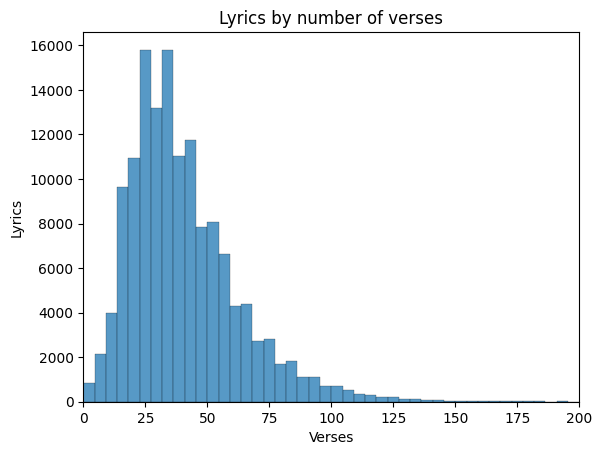

In [22]:
fig, ax = plt.subplots()
ax = sns.histplot(data=df, x='verses', bins=200)
ax.set_xlabel('Verses')
ax.set_ylabel('Lyrics')
ax.set_title('Lyrics by number of verses')
# There seems to be outliers
ax.set_xlim([0, 200])
plt.show()

In [23]:
df = df[df['verses']>20]

In [24]:
print(f'Number of lyrics {len(df)}')

Number of lyrics 119441


## Classification Dataset Preparation

In [25]:
# Get unique labels and compute value counts
df[df[genre_labels].sum(axis=1) == 1][genre_labels].sum(axis=0)

rock           19928
pop            15989
pop-rock        5151
heavy-metal     6201
indie           6737
hard-rock       1186
rap            19053
dtype: int64

In [26]:
# Drop songs with multiple genres
df.drop(df[df[genre_labels].sum(axis=1) > 1].index, inplace=True)
# Keep only rock, pop and rap lyrics:
# 1) Remove columns
df.drop(columns=['pop-rock','heavy-metal','indie','hard-rock'], inplace=True)
# 2) Remove rows
genre_labels = ['rock','pop','rap']
df.drop(df[df[genre_labels].sum(axis=1) == 0].index, inplace=True)

In [27]:
# Map again dummy variables to labels
df['genre'] = df[['rock', 'pop', 'rap']].apply(lambda x: 'rock' if x[0] == 1 else ('pop' if x[1] == 1 else ('rap' if x[2] == 1 else None)), axis=1)

# Drop dummy variables
df = df.drop(columns=['rock', 'pop', 'rap'])

df.head()

,lyrics,verses,genre
0,"[I feel so unsure, As I take your hand and lea...",47,pop
1,"[Don't let them fool, ya, Or even try to schoo...",28,pop
2,"[Baby, let's cruise, away from here, Don't be ...",26,pop
3,"[Know it sounds funny, But, I just can't stand...",31,pop
4,"[You've got that look again, The one I hoped I...",35,pop


In [28]:
df['genre'].value_counts()

rock    19928
rap     19053
pop     15989
Name: genre, dtype: int64

In [29]:
df = df[df['genre'] != 'pop'] 

In [30]:
df.reset_index(inplace=True, drop=True)
# Keep original index as id incase we want to retrieve samples in original df
df['id'] = df.index

In [31]:
df.drop(columns=['verses']).to_csv('../data/lyrics.csv', index=False)

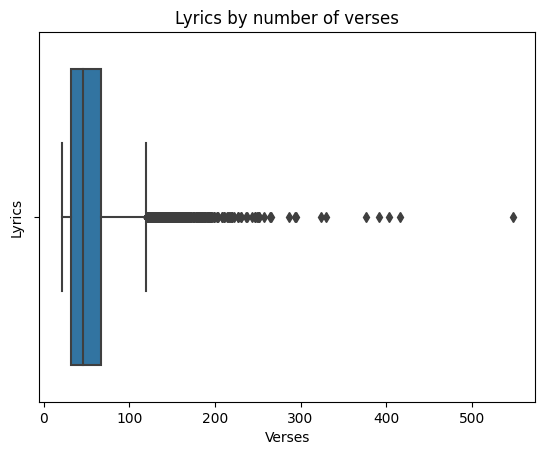

In [32]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x='verses')
ax.set_xlabel('Verses')
ax.set_ylabel('Lyrics')
ax.set_title('Lyrics by number of verses')
plt.show()

In [33]:
# Truncate long lyrics
df['lyrics'] = list(map(lambda x: x[:100] if len(x) > 100 else x, df['lyrics']))

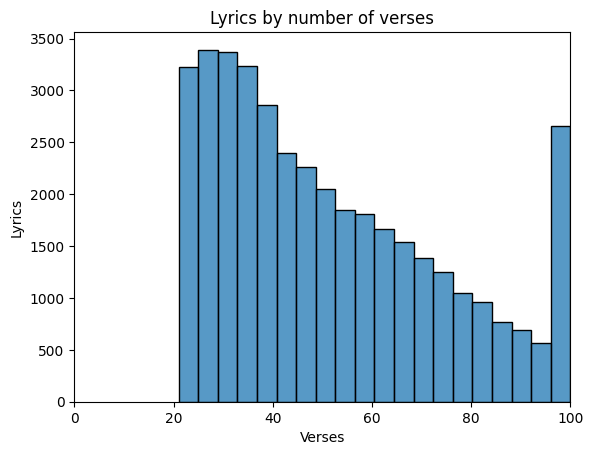

In [34]:
# count number of verses
df['verses'] = df['lyrics'].apply(len)
# Plot distribution
fig, ax = plt.subplots()
ax = sns.histplot(data=df, x='verses', bins=20)
ax.set_xlabel('Verses')
ax.set_ylabel('Lyrics')
ax.set_title('Lyrics by number of verses')
ax.set_xlim([0, 100])
plt.show()

In [35]:
df.reset_index(inplace=True, drop=True)
print(f'Number of lyrics {len(df)}')

Number of lyrics 38981


In [36]:
df_eval = df.groupby("genre").sample(n=50, weights='verses',random_state=0
).reset_index( 
).drop(columns=['verses'])

df_eval.to_csv('../data/evaluation/lyrics_eval.csv', index=False)

In [37]:
df.drop(columns=['verses'], inplace=True)

In [38]:
y = list(df['genre'])
X = list(zip(list(df['lyrics']),list(df['id'])))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [39]:
df_train = pd.DataFrame(X_train, columns=['lyrics','id'])
df_train['genre'] = y_train
df_train.shape

(31184, 3)

In [40]:
df_test = pd.DataFrame(X_test, columns=['lyrics','id'])
df_test['genre'] = y_test
df_test.shape

(7797, 3)

In [41]:
df_train.to_csv('../data/classification/lyrics_train.csv', index=False)
df_test.to_csv('../data/classification/lyrics_test.csv', index=False)

## Evaluation Dataset Preparation

In [42]:
import pandas as pd
import numpy as np
import random
import ast
from tqdm import tqdm
import nlpaug.augmenter.word as naw
from math import sqrt
from sklearn.model_selection import train_test_split

In [43]:
df = pd.read_csv('../data/evaluation/lyrics_eval.csv')

In [44]:
df.head()

,index,lyrics,genre,id
0,18107,"['You got, something that I do want', 'Somethi...",rap,18107
1,25551,"['You remind me of something...', ""I just can'...",rap,25551
2,19128,"['One more joog, one more', 'Joog ', ""Nigga, I...",rap,19128
3,18033,['Someone right now is leaving their apartment...,rap,18033
4,15604,"['When you said it was over', 'You shot right ...",rap,15604


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   100 non-null    int64 
 1   lyrics  100 non-null    object
 2   genre   100 non-null    object
 3   id      100 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ KB


In [46]:
df['lyrics'] = list(map(lambda x: ast.literal_eval(x), df['lyrics']))

In [47]:
eg_lyrics = random.choice(df['lyrics'])

In [48]:
aug = naw.ContextualWordEmbsAug(model_path='roberta-base', action="substitute")


In [49]:
def misalign_lyrics(lyrics, repetitions, repeat_verse):
    verses2repeat = random.sample(range(0, len(lyrics)), repetitions)
    misaligned_lyrics = []
    for idx, verse in enumerate(lyrics):
        if idx in verses2repeat:
            misaligned_lyrics.extend([verse] * repeat_verse)
        else:
            misaligned_lyrics.append(verse)
    return misaligned_lyrics

In [50]:
clf_test_ids = list(pd.read_csv('../data/classification/lyrics_test.csv')['id'])
evaluation_ids = list(df['id'])

idxs2remove = list(set(clf_test_ids + evaluation_ids))
all_lyrics = pd.read_csv('../data/lyrics.csv').drop(index=idxs2remove)['lyrics']
all_lyrics = list(map(lambda x: ast.literal_eval(x), all_lyrics))

In [51]:
eg_verse = random.choice(eg_lyrics)
print('Original verse:')
print(eg_verse)

print('Augmented:')
aug.augment(eg_verse)

Original verse:
Up against the wall
Augmented:


['Up against these Yankees']

In [52]:
eg_lyrics = random.choice(df['lyrics'])

eg_aug_lyrics = [aug.augment(verse)[0] for verse in tqdm(eg_lyrics)]
eg_aug_misl_lyrics = misalign_lyrics(eg_aug_lyrics, repetitions=round(sqrt(len(eg_lyrics))), repeat_verse=2)

eg_fake_lyrics = random.choice(all_lyrics)

print('ORIGINAL lyrics:')
print(eg_lyrics)
print()
print('AUGMENTED lyrics:')
print('Aligned:')
print(eg_aug_lyrics)
print()
print('Misaligned:')
print(eg_aug_misl_lyrics)
print()
print('RANDOM lyrics:')
print(eg_fake_lyrics)

100%|██████████| 49/49 [00:15<00:00,  3.09it/s]

ORIGINAL lyrics:
['The Beautiful Occupation Lyricsby Travis', 'Don´t just stand there watching it happening', 'I can´t stand it', 'Don´t feel it', 'Something´s telling me', 'Don´t wanna go out this way', 'But have a nice day', 'Then read it in the headlines', 'Watch it on the TV', 'Put it in the background', 'Stick it in the bag', 'Stick it in the bag', 'For the beautiful occupation', 'The beautiful occupation', 'You don´t need an invitation', 'To drop in upon a nation', 'I´m too cynical', 'I´m just sitting here', 'I´m just wasting my time', 'Half a million civillians gonna die today', 'But look the wrong way', 'Then read it in the headlines', 'Watch it on the TV', 'Put it in the background', 'Stick it in the bag', 'Stick it in the bag', 'For the beautiful occupation', 'The beautiful occupation', 'You don´t need an invitation', 'To drop in upon a nation', 'Don´t just stand there watching it happening', 'I can´t stand it', 'Don´t feel it', 'Something telling me', 'Don´t wanna go out thi

In [53]:
augment_many = lambda lyrics: [aug.augment(verse)[0] for verse in lyrics]

aug_lyrics = [augment_many(lyrics) for lyrics in tqdm(df['lyrics'])]
misl_aug_lyrics = [misalign_lyrics(aug_lyr, repetitions=round(sqrt(len(aug_lyr))), repeat_verse=random.choice([2,3])) for aug_lyr in tqdm(aug_lyrics)]

df['similar_lyrics'] = misl_aug_lyrics
df['random_lyrics'] = random.sample(all_lyrics, len(df['lyrics']))

100%|██████████| 100/100 [00:00<00:00, 35977.90it/s]


In [54]:
df.head()

,index,lyrics,genre,id,similar_lyrics,random_lyrics
0,18107,"[You got, something that I do want, Something ...",rap,18107,"[You got, for certain you do want, Something g...","[Suck on this!, Jan Pierewiet, Jan Pierewiet, ..."
1,25551,"[You remind me of something..., I just can't t...",rap,25551,"[You hate me for something..., I just can't pr...","[Someday at Christmas men won't be boys, Playi..."
2,19128,"[One more joog, one more, Joog , Nigga, I'm tu...",rap,19128,"[One grim year, five more, Joog, Nigga, very s...","[Bring over some of your old Motown records, W..."
3,18033,[Someone right now is leaving their apartment ...,rap,18033,[Someone right now is in their apartment way d...,"[Know I love you baby, Know I love you baby, Y..."
4,15604,"[When you said it was over, You shot right thr...",rap,15604,"[When you said is game over, You shot back thr...","[ ""You're from the valley?"", ""No, Jim you sch..."


In [55]:
df.to_csv('../data/evaluation/lyrics_eval.csv', index=False)